In [90]:
import numpy as np
import pandas
from scipy import stats
import queue as Q

class Oracle:
    """ Responsibilities
    1. To determine the class label for network's training examples
    2. To select split for each of the tree's internal nodes
    3. To determine, if the node covers instances of only one class
    """    
    
    def __init__(self, estimator, num_classes):
        self.estimator = estimator
        self.num_classes = num_classes

    def setDistributions(self, X):
        self.distributions =[]
        # 1. Kernel density estimate for Continuous features
        # 2. empirical estimate for discrete features
        # only consider continuous distributions
        self.dimension= X.shape[1]
        for i in range(0,self.dimension):
            values = X[:,i].reshape(X.shape[0])
            kernel = stats.gaussian_kde(values, bw_method='silverman')
            # print(kernel)
            # print(kernel.resample(1))
            self.distributions.append(kernel)

            
    def predict(self, example):
        value = self.estimator.predict(example)
        return value

    
# 	def oracle_constraints(self,constraints,n):
# 		#read each constraint
# 		X_examples= np.zeros((n,self.dimension))
# 		lab_examples = np.zeros(n)
# 		num_valid=0
# 		print(n)
# 		while(num_valid<n):
# 			sample=self.genSample(constraints)
# 			label=self.oracle_example(sample)
# 			X_examples[num_valid,:]=sample
# 			lab_examples[num_valid]=label
# 			num_valid+=1
# 			# print(num_valid)
											
# 		return (X_examples,lab_examples)

# 	#can be more efficient
# 	def genSample(self,constraints):
# 		sample = np.zeros(self.dimension)
# 		#assuming features have independent distributions
# 		for i in range(0,self.dimension):
# 			# print(i)
# 			done=False
# 			while not done :
# 				# print("THIS IS I :" +str(i))
# 				min_val = constraints.min_val(i)
# 				max_val = constraints.max_val(i)
# 				sample[i]=self.distributions[i].resample(1)[0]
# 				if sample[i] > min_val and sample[i] < max_val :
# 					done=True
# 		return sample

# 	def validSample(self,sample,constraints):
# 		for cons in constraints:
# 			(satisfied,splitrule)=cons
# 			if satisfied!=splitrule.satisfied(sample):
# 				# print("REJECTED")
# 				return False
# 		print("ACCEPTED")
# 		return True

In [62]:
class SplitRule:
	#<= is left , > is right
	#m of n split

	def __init__(self,splits,m,n):
		self.splits=splits
		self.m=m
		self.n=n
		self.op_dict= {"gte":self.gte,"lte":self.lte}
		self.processSplits()


	def processSplits(self):
		self.max_dict={}
		self.min_dict={}
		for (attr,op_string,val) in self.splits:
			if op_string in ["lte" ,"lt"]:
				if attr not in self.max_dict:
					self.max_dict[attr]=val
				self.max_dict[attr] = max(self.max_dict[attr],val)
			elif op_string in ["gte","gt"]:
				if attr not in self.min_dict:
					self.min_dict[attr]=val
				self.min_dict[attr] = min(self.min_dict[attr],val)

	#for building constraints
	def invert(self):
		splits2= []
		inverse = {"gte":"lt","gt":"lte","lte":"gt","lt":"gte"}
		for (attr,op_string,val) in self.splits:
			op_string=inverse[op_string]
			splits2.append((attr,op_string,val))
		s2 = SplitRule(splits2,self.m,self.n)
		return s2


	def gte(self,arg1, arg2):
		return arg1 >= arg2
	def lte(self,arg1, arg2):
		return arg1 <= arg2
	def lt(self,arg1,arg2):
		return arg1 < arg2
	def gt(self,arg1,arg2):
		return arg1 > arg2

	def satisfied(self,sample):
		sat=0

		for split in self.splits:
			(attr,op_string,val)=split
			op = self.op_dict[op_string]
			if op(sample[attr],val):
				sat+=1
			# print(attr,val)
			# print(sample[attr])
		if sat < self.m:
			return False
		else:
			return True

	def max_val(self,dim):
		if dim in self.max_dict :
			return self.max_dict[dim]
		else :
			return np.inf
	def min_val(self,dim):
		if dim in self.min_dict:
			return self.min_dict[dim]
		else :
			return -np.inf

In [144]:
class Node:
    def __init__(self, training_set, y_hat, total_size):
        self.leaf=True
        self.left=None
        self.right=None
        self.split_rule=None
        self.num_examples= training_set[0].shape[0]

        if self.num_examples==0:
            self.priority=0
            print("NEW NODE! with priority = "+ str(self.priority))
            return

        self.dominant = self.getDominantClass(training_set[1])
        self.misclassified=self.getMisclassified(training_set[1], y_hat)
        self.fidelity = 1 - (float(self.misclassified)/self.num_examples)
        self.reach = float(self.num_examples)/total_size
        self.priority = (-1)*self.reach* (1 - self.fidelity)
        # print(self.fidelity,self.reach,self.num_examples)
        print("NEW NODE! with priority = "+ str(self.priority))

        
    def getDominantClass(self, y):
        labels = np.unique(y)
        label_summary = {}
        for label in labels:
            label_summary[label] = len(y[y == label])
        return max(label_summary.items(), key=operator.itemgetter(1))[0]
    
    
    def getMisclassified(self, y, y_hat):
        in_correct_prediction = np.where(y_hat != y)
        return len(in_correct_prediction)

    
#     def classify(self,sample):
#         if self.leaf :
#             return self.dominant
#         if self.splitrule.satisfied(sample):
#             return self.left.classify(sample)
#         else:
#             return self.right.classify(sample)

In [160]:
class Constraints :

    def __init__(self, num_dim):
        # self.cons_list=[]
        self.num_dim = num_dim
        self.max_list = np.zeros(num_dim)
        self.min_list = np.zeros(num_dim)

    def addRule(self, split):
        for i in range(0, self.num_dim):
            self.max_list[i]=max(self.max_list[i], split.max_val(i))
            self.min_list[i]=min(self.min_list[i], split.min_val(i))

    def max_val(self,dim):
        return self.max_list[dim]

    def min_val(self, dim):
        return self.min_list[dim]

    def copy(self):
        c = Constraints(self.num_dim)
        c.max_list=np.copy(self.max_list)
        c.min_list=np.copy(self.min_list)
        return c

In [181]:
def entropy(counts, n):
    res=0
    for key in counts:
        c = counts[key]
        if (c==0):
            continue
        p = float(c)/n
        # print(p)
        res-=p*np.log2(p)

    return res

def entropy_2(label_dict):
    probabilities = [n_x/len(s) for x, n_x in label_dict]

In [225]:
def mutual_information(X, y):
    gains = np.zeros(X.shape)
    n = X.shape[0]
    ind_array = np.argsort(X)
    labels, counts = np.unique(y, return_counts=True)
    lcounts={}
    rcounts={}
    if (X.shape[0]!=y.shape[0]):
        print("ERROR ")

    for i in range(0,labels.shape[0]):
        lcounts[labels[i]]=counts[i]
        rcounts[labels[i]]=0

    e_parent = entropy(lcounts,n)
    temp = np.zeros((n,1))
    j=0
    prev=-1
    #process in reverse, to deal with identical values
    for i in reversed(ind_array):
        print('index:{}'.format(i))
        lab = y[i]
        print(lab)
        # print(lcounts)
        # print(rcounts)
        #fixed error in iterative loading, didn't consider the case that many 
        #indices can lead to same split
        if (prev >=0 and X.iloc[prev]==X.iloc[i]):
            gains[i]=gains[prev]
            j+=1
            rcounts[lab]+=1
            lcounts[lab]-=1	
            continue
        prev=i

        f_r=(float(j)/n)
        f_l=1-f_r
        e_r=f_r *entropy(rcounts,n)
        e_l =f_l* entropy(lcounts,n) #weighted entropies
        gains[i]= e_parent-(e_l+e_r)
        temp[i]=j
        j+=1

        rcounts[lab]+=1
        lcounts[lab]-=1


#         if printnow  and j==n:
#             print (str(i) + " : LEFT "+ str(f_l*entropy(lcounts,n))+" RIGHT "+str(f_r*entropy(rcounts,n)))
#             pdb.set_trace()
#             entropy(lcounts,n)
#             print( "PROBS : "+str(f_l)+" : "+str(f_r))
#             print("GAIN : "+str(gains[i]))
    return gains


# usual c4.5 split only for now
def bestMofNSplit(examples):
    (X, labels) = examples
    n_rows = X.shape[0]
    dim = X.shape[1]
    print("SPLITTING "+str(n)+" EXAMPLES")
    gains = np.zeros((n_rows, dim))
    for i in range(0, dim):
        gains[:,i] = mutual_information(X[:,i],labels)
    split_point = np.unravel_index(np.argmax(gains),gains.shape)
    if (np.max(gains)<1e-6):
        return None
    # print(split_point)
    # print(gains[split_point])
    srule= SplitRule([(split_point[1], "lte", X[split_point])], 1, 1)
    return srule


# def partition(examples,srule):
# 	(X,Y) = examples
# 	n = X.shape[0]
# 	# print(X[1:5,:])
# 	el=[]
# 	er=[]
# 	for i in range(0,n):
# 		if srule.satisfied(X[i,:]):
# 			el.append(i)
# 		else:
# 			er.append(i)
# 	print(len(el))
# 	print(len(er))
# 	examples_l = (X[el,:],Y[el])
# 	examples_r = (X[er,:],Y[er])

# 	return examples_l,examples_r

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)
X = df
y = iris.target
print(len(y))

150


In [71]:
# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=5, class_weight="balanced", oob_score=True, random_state=1)
clf.fit(X, y)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [247]:
clf.predict(X.iloc[0:1])

# Decision Path
clf.decision_path(X.iloc[0:1])

(<1x87 sparse matrix of type '<class 'numpy.int64'>'
 	with 14 stored elements in Compressed Sparse Row format>,
 array([ 0, 25, 36, 51, 70, 87]))

In [251]:
y_hat = clf.predict(X_test)
np.unique(y_hat)

array([0, 1, 2])

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat, target_names=target_names))


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       1.00      1.00      1.00        15
    class 2       1.00      1.00      1.00        16

avg / total       1.00      1.00      1.00        50



In [260]:
from sklearn.tree import DecisionTreeClassifier

explainer = DecisionTreeClassifier(random_state=0)
explainer.fit(X_test, y_hat)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [261]:
y_hat_surrogate = explainer.predict(X_test)
print("\n-------- Test dataset classification report on Surrogate ----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_hat, y_hat_surrogate, target_names=target_names))


-------- Test dataset classification report on Surrogate ----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       1.00      1.00      1.00        15
    class 2       1.00      1.00      1.00        16

avg / total       1.00      1.00      1.00        50



In [263]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(explainer, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=iris.feature_names, class_names=iris.target_names)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

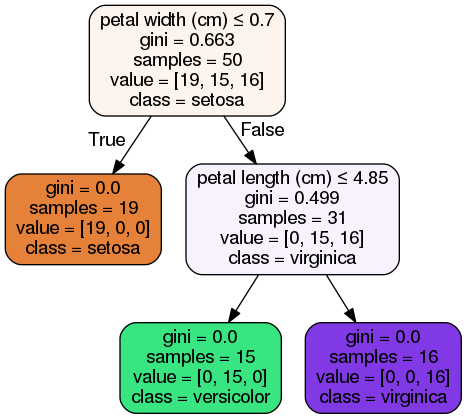

In [264]:
from IPython.display import Image
Image(graph.create_png())

In [241]:
from sklearn.feature_selection import mutual_info_classif

feature_scores = mutual_info_classif(X_train.iloc[0:1], y_train[0])
feature_scores

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [224]:
X_train.iloc[:, 0].shape

(100,)

In [234]:
gains = np.zeros((total_size, 4))
for i in range(0, 3):
    gains[:,i] = mutual_information(X_train.iloc[:, i], y_train)

(100,)
96     47
105    46
66     52
0      71
122    50
67     55
28     18
40     58
44     11
60     82
123    79
24     96
25     84
23     35
94     32
39      7
95     31
117    37
47     29
97     38
113    12
33      9
138    51
101    13
62      3
84     40
148    78
53     64
5      15
93      8
       ..
91     87
41     53
58     10
90     54
48     57
88     91
107    30
124    63
21     67
57     89
144    60
129    72
37     77
140    80
1      83
52     34
130    56
103    85
99     65
116    41
87     62
74     99
121    81
149    49
20     76
71     86
106     1
14     44
92     17
102     4
Name: sepal length (cm), Length: 100, dtype: int64
index:65
2
index:73
1
index:38
0
index:47
0
index:31
0
index:32
0
index:8
0
index:17
2
index:87
2
index:54
2
index:68
1
index:91
1
index:62
1


KeyError: 86

In [216]:
X_train.iloc[86]
print(y_train[86])

2


In [183]:
l, c = np.unique(y_train, return_counts=True)

[0 1 2] [31 35 34]


In [145]:
num_classes = len(iris.target_names)
oracle = Oracle(clf, num_classes)
training_set = (X_train, y_train)

In [146]:
y_hat = oracle.predict(np.array(X_train))

In [147]:
import queue as Q
sortedQueue = Q.PriorityQueue()

In [189]:
total_size = X_train.shape[0]
num_dim = X_train.shape[1]
print(total_size)
print(num_dim)

100
4


In [230]:
# Construct the tree
root = Node(training_set, y_hat, total_size)

root.leaf=False
sortedQueue.put((root.priority, (0, root, training_set, Constraints(num_dim))))

NEW NODE! with priority = -0.010000000000000009


In [233]:
# Algorithm:
tree_size_limit = 100 #arbitary number right now
while not sortedQueue.empty() & sortedQueue.qsize() < tree_size_limit:
    (p, (t, node, examples, constraints)) = sortedQueue.get()
    num_ex=examples[0].shape[0]
    print("############PROCESSING "+str(num_ex)+" #############")
    examples_aug = examples
    
    # best possible split

In [231]:
print(sortedQueue.qsize())

1
